In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

## Loads images from subfolders, where each subfolder name is treated as a class label.

* Converts each image into a numerical tensor (multi-dimensional array) so it can be used by the model.

* Resizes all images to 256x256

* Returns a tf.data.Dataset of (image, label) pairs, batched by 32.

* shuffle=True ensures the images are randomly ordered for training

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size = (IMAGE_SIZE, IMAGE_SIZE) ,
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

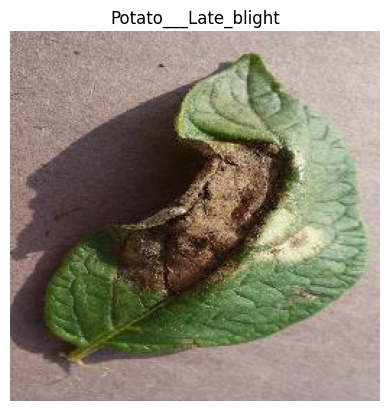

(256, 256, 3)


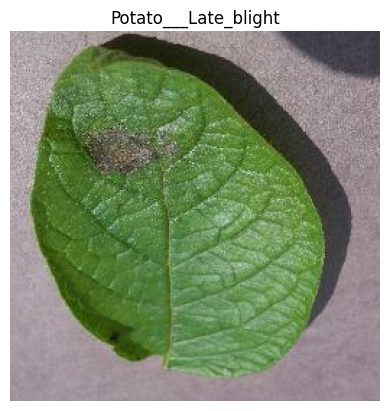

(256, 256, 3)


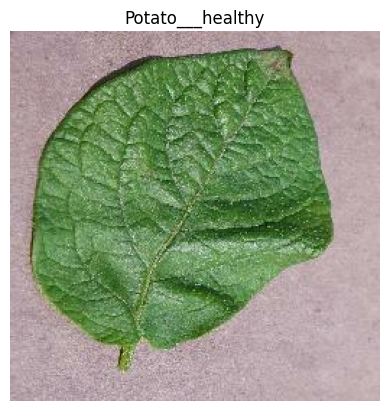

(256, 256, 3)


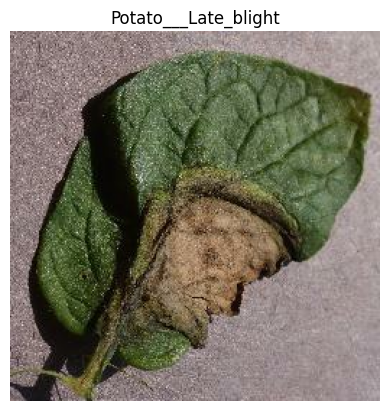

(256, 256, 3)


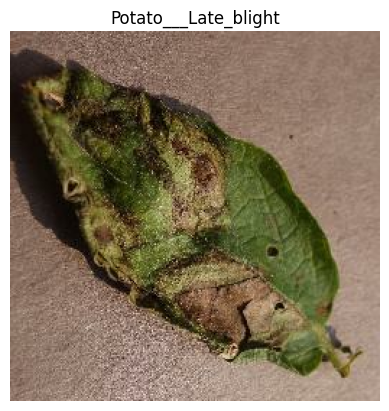

(256, 256, 3)


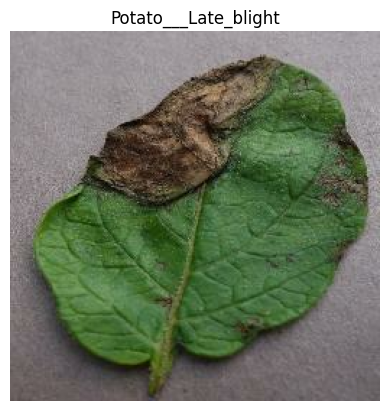

(256, 256, 3)


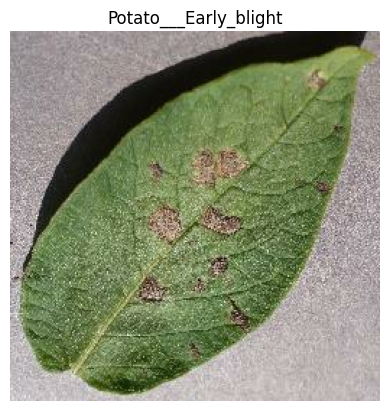

(256, 256, 3)


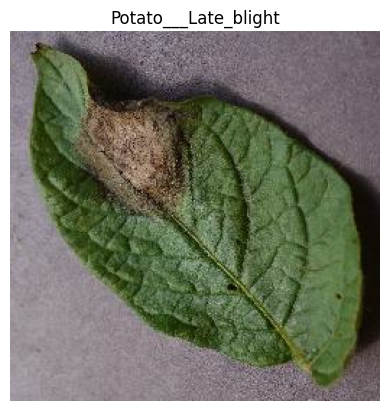

(256, 256, 3)


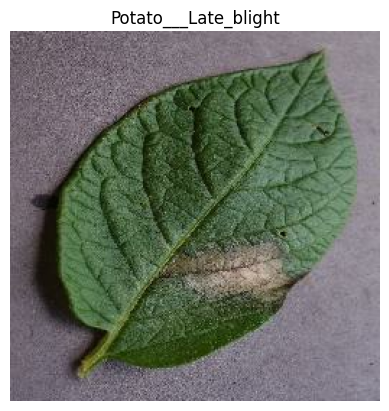

(256, 256, 3)


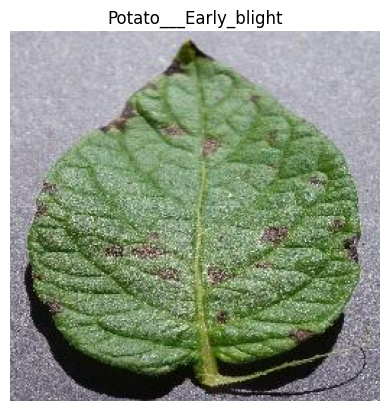

(256, 256, 3)


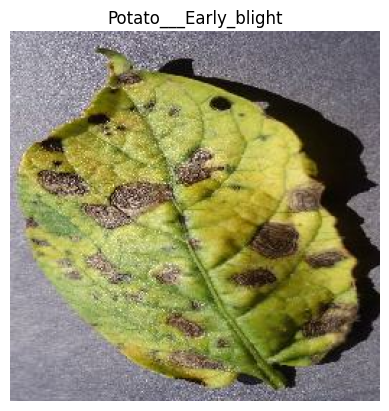

(256, 256, 3)


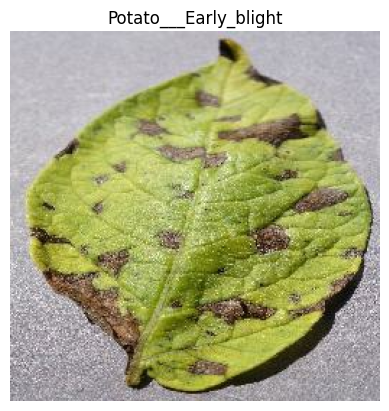

(256, 256, 3)


In [20]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(dataset.class_names[label_batch[i]])
        plt.show()  # Needed to display each image
        print(image_batch[i].shape)  # Print the shape for each image


In [21]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [31]:
train_ds= dataset.take(54)
len(train_ds)

54

In [32]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [33]:
val_ds = test_ds.take(6)
len (val_ds)

6

In [34]:
test_ds = test_ds.skip(6)
len(test_ds)

8

* This function splits a TensorFlow dataset into training, validation, and test subsets.

* You can control the percentage split via parameters (train_split, val_split, test_split).

* Optionally shuffles the dataset before splitting, using a buffer of shuffle_size.

* Returns three datasets: train_ds, val_ds, and test_ds, each representing a portion of the original dataset

In [36]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds. shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size). take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds)

54

In [39]:
len(val_ds)

6

In [40]:
len(test_ds)

8

## cache()

* Stores the dataset in memory after the first epoch.

* Greatly speeds up data access in subsequent epochs.

* Especially useful when the dataset fits in memory.

## shuffle(1000)

* Randomly mixes the order of elements using a buffer of 1000.

* Helps improve model generalization by preventing it from seeing data in the same order.

* Should typically be used only on the training set — no need to shuffle validation/test data.

## prefetch(tf.data.AUTOTUNE)

* Allows the pipeline to fetch the next batch while the current batch is being processed by the model.

* AUTOTUNE lets TensorFlow choose the optimal number of batches to prefetch.

* Reduces GPU/CPU idle time, speeding up training.



In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data Augmentation

In [ ]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
layers.experimental.preprocessing.Rescaling (1.0/255)
])

In [ ]:
data_augmentation = tf. keras. Sequential([
layers. experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
layers. experimental preprocessing.RandomRotation (0.2),
])